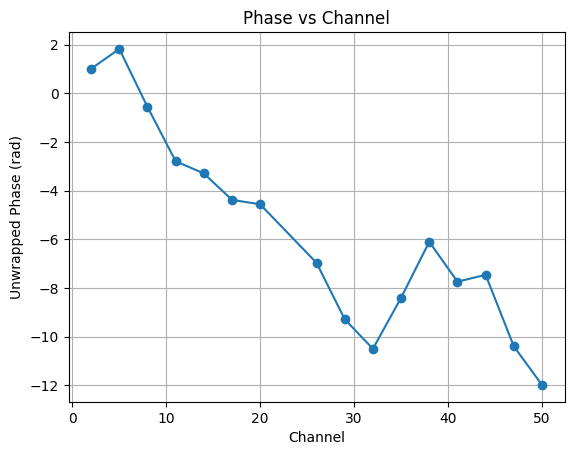

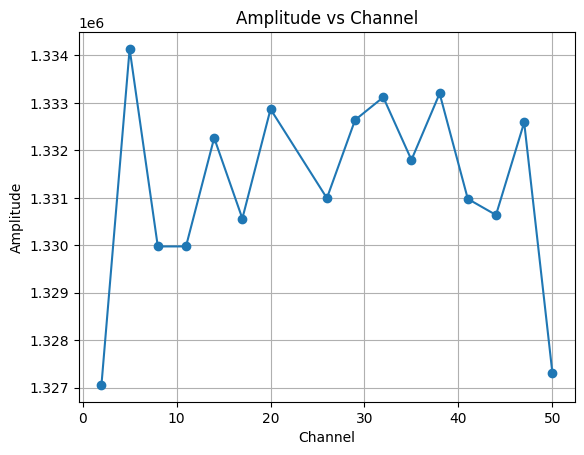

Phase slope: -0.24121817373280074
Estimated distance (meters): 5.754675827799873


NameError: name 'parsed_data' is not defined

In [ ]:
import re
from collections import defaultdict
import matplotlib.pyplot as plt

# import re
import numpy as np
import matplotlib.pyplot as plt

def parse_new_iq_logs(log_lines):
    """
    解析新的IQ数据输出，返回每个ranging_counter的字典：
    {counter: [{'channel':xx, 'li':xx, 'lq':xx, 'pi':xx, 'pq':xx, ...}, ...]}
    """
    ranging_counter = None
    data_per_counter = {}
    current_data = []
    for line in log_lines:
        # 检测ranging counter
        m = re.search(r'I: Ranging data get completed for ranging counter (\d+)', line)
        if m:
            if ranging_counter is not None and current_data:
                data_per_counter[ranging_counter] = current_data
            ranging_counter = int(m.group(1))
            current_data = []
        # 检测IQ数据行
        m = re.match(r'id:(\d+), f:(\d+), ch:(\d+), ap:(\d+), li:(-?\d+), lq:(-?\d+), pi:(-?\d+), pq:(-?\d+)', line)
        if m:
            entry = {
                'id': int(m.group(1)),
                'failed': int(m.group(2)),
                'channel': int(m.group(3)),
                'ap': int(m.group(4)),
                'li': int(m.group(5)),
                'lq': int(m.group(6)),
                'pi': int(m.group(7)),
                'pq': int(m.group(8)),
            }
            current_data.append(entry)
    # 最后一组数据
    if ranging_counter is not None and current_data:
        data_per_counter[ranging_counter] = current_data
    return data_per_counter

def cs_frequency_mhz(ch):
    # 假设蓝牙LE物理信道编号2~39对应2404~2480 MHz，每ch+2402
    return 2402 + ch

def process_iq_samples(iq_entries):
    """
    输入某次ranging下所有信道的IQ原始数据，输出channels, frequencies, amplitude, phase（相位已unwrap）
    """
    results = []
    for entry in iq_entries:
        if entry['failed']:
            continue
        li, lq, pi, pq = entry['li'], entry['lq'], entry['pi'], entry['pq']
        # 复数乘积 (li + lq*j) × (pi - pq*j)
        combined_i = li * pi + lq * pq
        combined_q = lq * pi - li * pq
        # 幅值和相位角
        amplitude = np.hypot(combined_i, combined_q)
        theta = np.arctan2(combined_q, combined_i)
        freq = cs_frequency_mhz(entry['channel'])
        results.append({'channel': entry['channel'], 'frequency': freq, 'amplitude': amplitude, 'theta': theta})
    # 按频率排序
    results.sort(key=lambda x: x['frequency'])
    # 相位展开
    theta_list = [x['theta'] for x in results]
    theta_unwrapped = np.unwrap(theta_list)
    for idx, t in enumerate(theta_unwrapped):
        results[idx]['theta_unwrapped'] = t
    return results

def plot_phase_vs_channel(results):
    chs = [x['channel'] for x in results]
    ths = [x['theta_unwrapped'] for x in results]
    plt.plot(chs, ths, 'o-')
    plt.xlabel('Channel')
    plt.ylabel('Unwrapped Phase (rad)')
    plt.title('Phase vs Channel')
    plt.grid()
    plt.show()

def plot_amplitude_vs_channel(results):
    chs = [x['channel'] for x in results]
    amps = [x['amplitude'] for x in results]
    plt.plot(chs, amps, 'o-')
    plt.xlabel('Channel')
    plt.ylabel('Amplitude')
    plt.title('Amplitude vs Channel')
    plt.grid()
    plt.show()



# 解析日志的函数
def parse_logs(log_lines):
    # 初始化存储结构
    data = defaultdict(lambda: defaultdict(list))
    current_ranging_counter = None

    # 正则表达式匹配
    ranging_ready_pattern = re.compile(r"I: Ranging data ready (\d+)")
    channel_data_pattern = re.compile(r"I: ch\[(\d+)\] : ([\-\d\.]+) radians")

    # 逐行解析日志
    for line in log_lines:
        # 检查是否是新的探测次数
        ranging_match = ranging_ready_pattern.search(line)
        if ranging_match:
            current_ranging_counter = int(ranging_match.group(1))
            continue

        # 检查是否是信道数据
        channel_match = channel_data_pattern.search(line)
        if channel_match and current_ranging_counter is not None:
            channel = int(channel_match.group(1))
            phase = float(channel_match.group(2))
            # 存储数据
            data[current_ranging_counter][channel].append(phase)

    return data

# 从文件加载日志数据
def load_log_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        log_lines = file.readlines()
    return log_lines

# 绘图函数
def plot_data(parsed_data, ranging_counter):
    if ranging_counter not in parsed_data:
        print(f"No data for ranging counter {ranging_counter}")
        return

    channels = parsed_data[ranging_counter]
    for channel, phases in channels.items():
        plt.plot([channel] * len(phases), phases, 'o', label=f"Channel {channel}")

    plt.xlabel("Channel Number")
    plt.ylabel("Phase (radians)")
    plt.title(f"Ranging Counter {ranging_counter} - Phase vs Channel")
    plt.legend()
    plt.grid()
    plt.show()

# 去除共模的函数
def remove_common_mode(parsed_data):
    # 输出新结构：共模去除后的数据
    denoised_data = defaultdict(lambda: defaultdict(list))
    for ranging_counter, channels in parsed_data.items():
        # 获取所有信道的相位样本（扁平化合并）
        all_phases = []
        for phases in channels.values():
            all_phases.extend(phases)
        if not all_phases:
            continue
        # 计算共模分量（均值）
        common_mode = sum(all_phases) / len(all_phases)
        # 每个信道减去共模
        for channel, phases in channels.items():
            denoised_phases = [phase - common_mode for phase in phases]
            denoised_data[ranging_counter][channel] = denoised_phases
        
        print(f"Ranging {ranging_counter}: common_mode = {common_mode}")
    return denoised_data

# 主函数
if __name__ == "__main__":


    # 1. 读入你的txt文本文件
    log_lines = []
    with open('iqtest1.txt', 'r', encoding='utf-8') as f:
        log_lines = f.readlines()

    # 2. 解析
    data_per_counter = parse_new_iq_logs(log_lines)

    # 3. 选择某一个ranging_counter分析，如最新的一个
    last_counter = sorted(data_per_counter.keys())[-1]
    iq_entries = data_per_counter[last_counter]
    results = process_iq_samples(iq_entries)

    # 4. 画图
    plot_phase_vs_channel(results)
    plot_amplitude_vs_channel(results)

    # 5. 你可以进一步分析各信道的相位斜率、回归、距离等
    frequencies = np.array([x['frequency'] for x in results])
    phases = np.array([x['theta_unwrapped'] for x in results])
    slope, intercept = np.polyfit(frequencies, phases, 1)
    print('Phase slope:', slope)
    # 距离估算（和MCU一致）
    SPEED_OF_LIGHT_M_PER_S = 299792458.0
    distance = -slope * (SPEED_OF_LIGHT_M_PER_S / (4 * np.pi)) / 1e6
    print('Estimated distance (meters):', distance)

    # # 绘制第 0 次信道探测的结果
    plot_data(last_counter, ranging_counter=0)

    # # 绘制第 1 次信道探测的结果
    plot_data(parsed_data, ranging_counter=1)

In [ ]:
# 计算信道平均相位值的函数
def calculate_channel_averages(parsed_data):
    channel_averages = defaultdict(list)  # 每个信道的平均相位值列表

    # 遍历每次信道探测的结果
    for ranging_counter, channels in parsed_data.items():
        for channel, phases in channels.items():
            # 计算均值并保存
            average_phase = sum(phases) / len(phases)
            channel_averages[channel].append((ranging_counter, average_phase))

    return channel_averages

# 绘制信道变化曲线的函数
def plot_channel_variation(channel_averages, channels_to_plot):
    plt.figure(figsize=(60, 12))

    for channel in channels_to_plot:
        if channel in channel_averages:
            data = channel_averages[channel]
            ranging_counters = [item[0] for item in data]  # 信道探测次数
            average_phases = [item[1] for item in data]    # 平均相位值
            plt.plot(ranging_counters, average_phases, label=f"Channel {channel}")
        else:
            print(f"Channel {channel} not found in the data.")


    plt.xlabel("Ranging Counter")
    plt.ylabel("Average Phase (radians)")
    plt.title("Channel Phase Variation Over Ranging Counters")
    plt.legend()
    plt.grid()
    plt.show()


def plot_channel_phase_diff(channel_averages, channels_to_plot):
    """
    画相邻信道的相位差随Ranging Counter的变化曲线。
    """
    plt.figure(figsize=(20, 12))
    for i in range(1, len(channels_to_plot)):
        ch1 = channels_to_plot[i-1]
        ch2 = channels_to_plot[i]
        if ch1 in channel_averages and ch2 in channel_averages:
            # 拿到两个信道的ranging和相位
            data1 = dict(channel_averages[ch1])
            data2 = dict(channel_averages[ch2])
            # 只取两个信道都有数据的counter
            shared_counters = sorted(set(data1.keys()) & set(data2.keys()))
            phase_diffs = [data2[cnt] - data1[cnt] for cnt in shared_counters]
            plt.plot(shared_counters, phase_diffs, label=f"Ch{ch2}-Ch{ch1}")
        else:
            print(f"Channel {ch1} or {ch2} not found in data.")

    plt.xlabel("Ranging Counter")
    plt.ylabel("Phase Difference (radians)")
    plt.title("Adjacent Channel Phase Difference Over Ranging Counters")
    plt.legend()
    plt.grid()
    plt.show()


    # 计算每个信道的平均相位值以去除共模噪声，再进行后续计算
# denoised_data = remove_common_mode(parsed_data)
# channel_averages = calculate_channel_averages(denoised_data)
# 计算每个信道的平均相位值
channel_averages = calculate_channel_averages(iq)

# 指定要绘制的信道
# channels_to_plot = [2, 10, 20, 30, 40, 50, 60, 70, 76]  # 你可以修改为需要展示的信道
# channels_to_plot = [2,  5,  8,  11, 14, 17, 20, 23, 26, 29, 32,35, 38, 41, 44, 47, 50]  # 你可以修改为需要展示的信道
channels_to_plot = [2,   8,   14,  20,  26,  32, 38,  44,  50]  # 展示的信道pcd.itv.4.cable
# channels_to_plot = [2,   50]  # 展示的信道far.long.test

plot_channel_variation(channel_averages, channels_to_plot)
# plot_channel_phase_diff(channel_averages, channels_to_plot)

AttributeError: 'int' object has no attribute 'items'


上图所示，似乎会有一些随机误差，但又谈不上是随机的，因为每个channel 的变化都是一样的，我可以用这些值滤波吗？